# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions
* Partially adopted from DS-GA 1008

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [ ]:
!wget https://data.deepai.org/mnist.zip
!mkdir -p data/MNIST/raw
!unzip mnist.zip -d data/MNIST/raw

--2021-03-11 19:30:29--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597176 (11M) [application/x-zip-compressed]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  11.06M  12.5MB/s    in 0.9s    

2021-03-11 19:30:30 (12.5 MB/s) - ‘mnist.zip’ saved [11597176/11597176]

Archive:  mnist.zip
  inflating: data/MNIST/raw/train-labels-idx1-ubyte.gz  
  inflating: data/MNIST/raw/train-images-idx3-ubyte.gz  
  inflating: data/MNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: data/MNIST/raw/t10k-labels-idx1-ubyte.gz  


In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

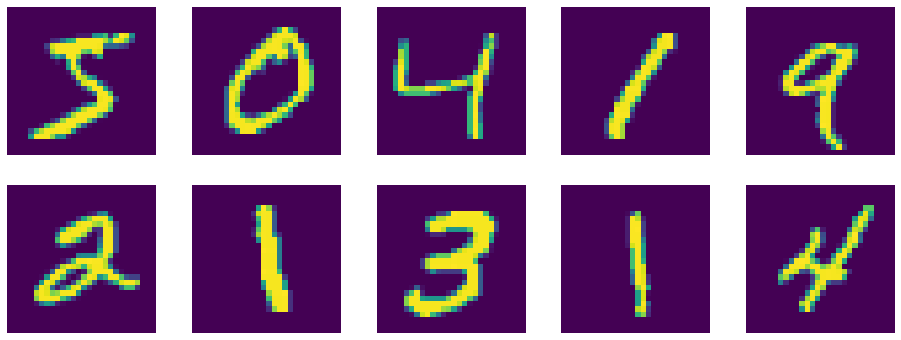

In [ ]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    image = image.permute(1,2,0)
    image *= 0.5
    image += 0.5
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [ ]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # send to device
            data, target = data.to(device), target.to(device)

            # permute pixels
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [ ]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312606
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.812596
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.452506
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.026160
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.668000
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.786609
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.526249
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.717420
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.666943
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.470984

Test set: Average loss: 0.4212, Accuracy: 8730/10000 (87%)



# Train a ConvNet with the same number of parameters

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303946
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.370583
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.400469
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.508846
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.383421
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.301953
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.267986
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.181445
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.166182
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.206062

Test set: Average loss: 0.1462, Accuracy: 9568/10000 (96%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


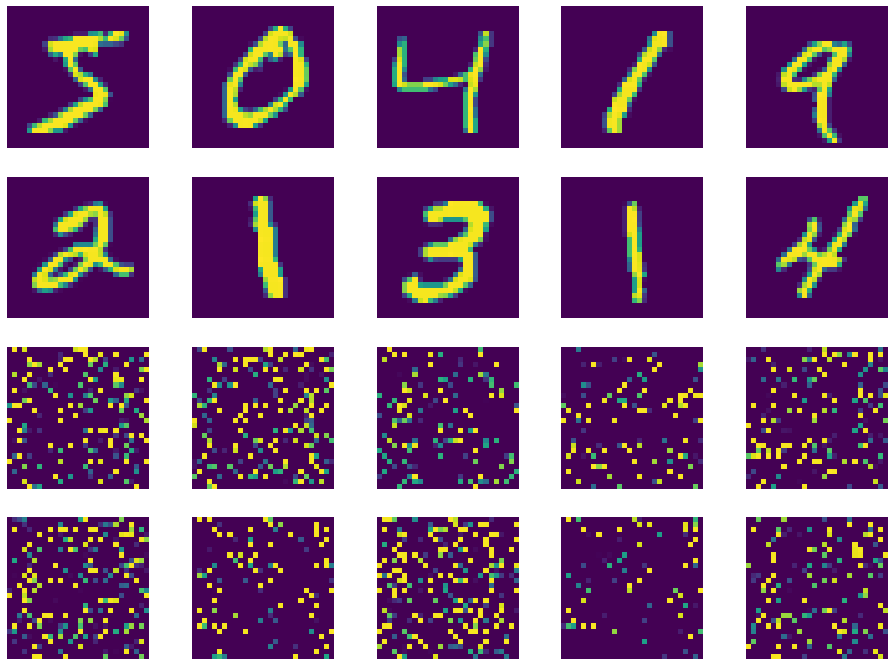

In [ ]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299033
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.251571
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.095186
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.490672
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.152397
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.992692
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.524043
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.503291
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.556897
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.685252

Test set: Average loss: 0.5807, Accuracy: 8078/10000 (81%)



# Fully-Connected with Permuted Pixels

In [ ]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.330238
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.918977
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.391353
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.859460
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.654081
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.730766
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.556502
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.638315
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.564734
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.490259

Test set: Average loss: 0.4679, Accuracy: 8602/10000 (86%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

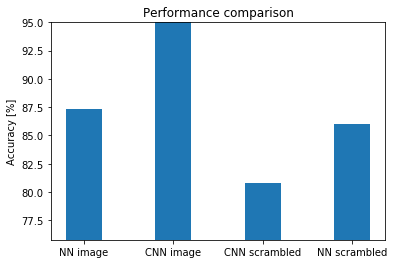

In [ ]:
plt.bar(['NN image']+['CNN image']+['CNN scrambled']+['NN scrambled'],
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 95))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');

# Some Regularizaton

* BatchNormalization
* Dropout

In [ ]:

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_loader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('./data', train=True, download=True,
                                           transform=transform),
                                           batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('./data', train=False, download=True,
                                          transform=transform),
                                          batch_size=1000, shuffle=True)

# See for https://pytorch.org/tutorials/beginner/data_loading_tutorial.html customized dataset

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*5*5, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

    
class CNN_BN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_BN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*5*5, 50)
        self.bn3 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*5*5)
        x = self.fc1(x)
        x = F.relu(self.bn3(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    
class CNN_DROP(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_DROP, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*5*5, 50)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    

In [ ]:
accuracy_list = []

def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # send to device
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [ ]:
# Training settings 
n_features = 6 # number of feature maps
input_size = 32*32
output_size = 10

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 5):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 9422
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.298357
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.295364
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.289302
Train Epoch: 0 [19200/50000 (38%)]	Loss: 2.236290
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.152226
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.078535
Train Epoch: 0 [38400/50000 (77%)]	Loss: 2.059348
Train Epoch: 0 [44800/50000 (90%)]	Loss: 2.021761

Test set: Average loss: 1.9785, Accuracy: 2808/10000 (28%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.118650
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.877557
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.901126
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.723496
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.812577
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.633827
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.765674
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.811886

Test set: Average loss: 1.7503, Accuracy: 3343/10000 (33%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.748938
Train Epoch: 2 [64

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn_bn = CNN_BN(input_size, n_features, output_size)
model_cnn_bn.to(device)
optimizer = optim.SGD(model_cnn_bn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_bn)))

for epoch in range(0, 5):
    train(epoch, model_cnn_bn)
    test(model_cnn_bn)

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn_drop = CNN_DROP(input_size, n_features, output_size)
model_cnn_drop.to(device)
optimizer = optim.SGD(model_cnn_drop.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_drop)))

for epoch in range(0, 5):
    train(epoch, model_cnn_drop)
    test(model_cnn_drop)